In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [3]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


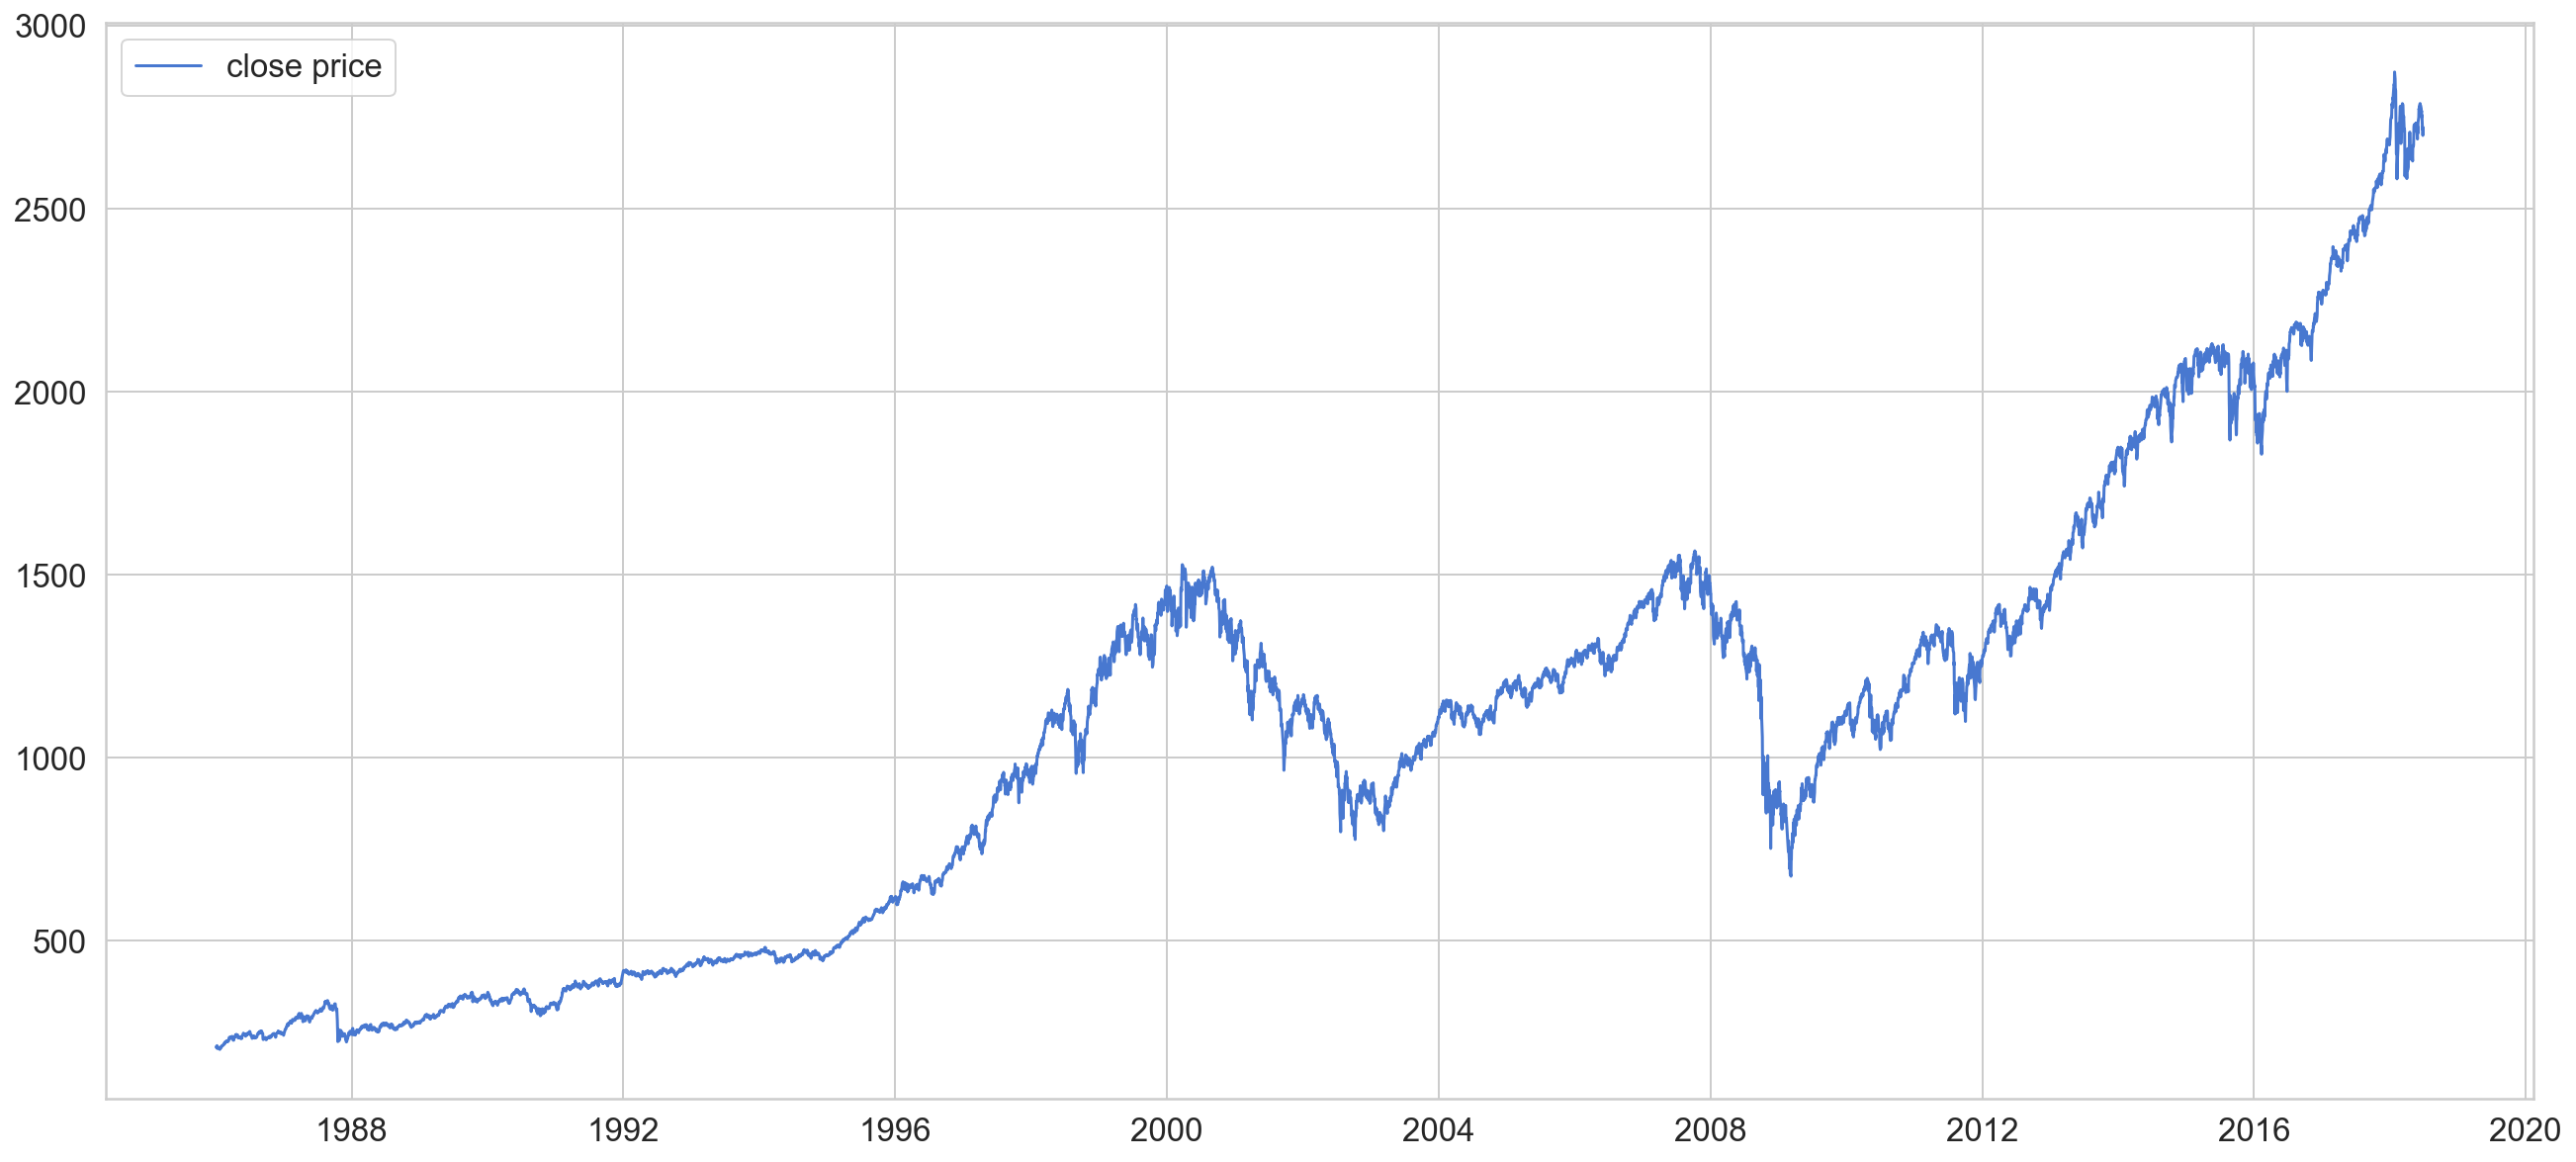

In [4]:
plt.plot(df, label='close price')
plt.legend();

In [5]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3896\1827044255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3896\1827044255.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [19]:
model = keras.Sequential()
model.add(keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(32, activation='relu', return_sequences=False))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(32, activation='relu', return_sequences=True))
model.add(keras.layers.LSTM(64, activation='relu', return_sequences=True))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 32)           0         
 or)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_5 (LSTM)               (None, 30, 64)            24832     
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            65        
 tributed)                                            

In [23]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 11s 50ms/step - loss: 0.1039 - val_loss: 0.2283
Epoch 2/10
218/218 [==============================] - 13s 61ms/step - loss: 0.0835 - val_loss: 0.2058
Epoch 3/10
218/218 [==============================] - 13s 58ms/step - loss: 0.0975 - val_loss: 0.2688
Epoch 4/10
218/218 [==============================] - 16s 75ms/step - loss: 0.0900 - val_loss: 0.3162
Epoch 5/10
218/218 [==============================] - 13s 58ms/step - loss: 0.0925 - val_loss: 0.2114
Epoch 6/10
218/218 [==============================] - 13s 61ms/step - loss: 0.0975 - val_loss: 0.3014
Epoch 7/10
218/218 [==============================] - 11s 53ms/step - loss: 0.0946 - val_loss: 0.2805
Epoch 8/10
218/218 [==============================] - 11s 51ms/step - loss: 0.0910 - val_loss: 0.2849
Epoch 9/10
218/218 [==============================] - 14s 65ms/step - loss: 0.0907 - val_loss: 0.3257
Epoch 10/10
218/218 [==============================] - 12s 57ms/step - loss: 0.094

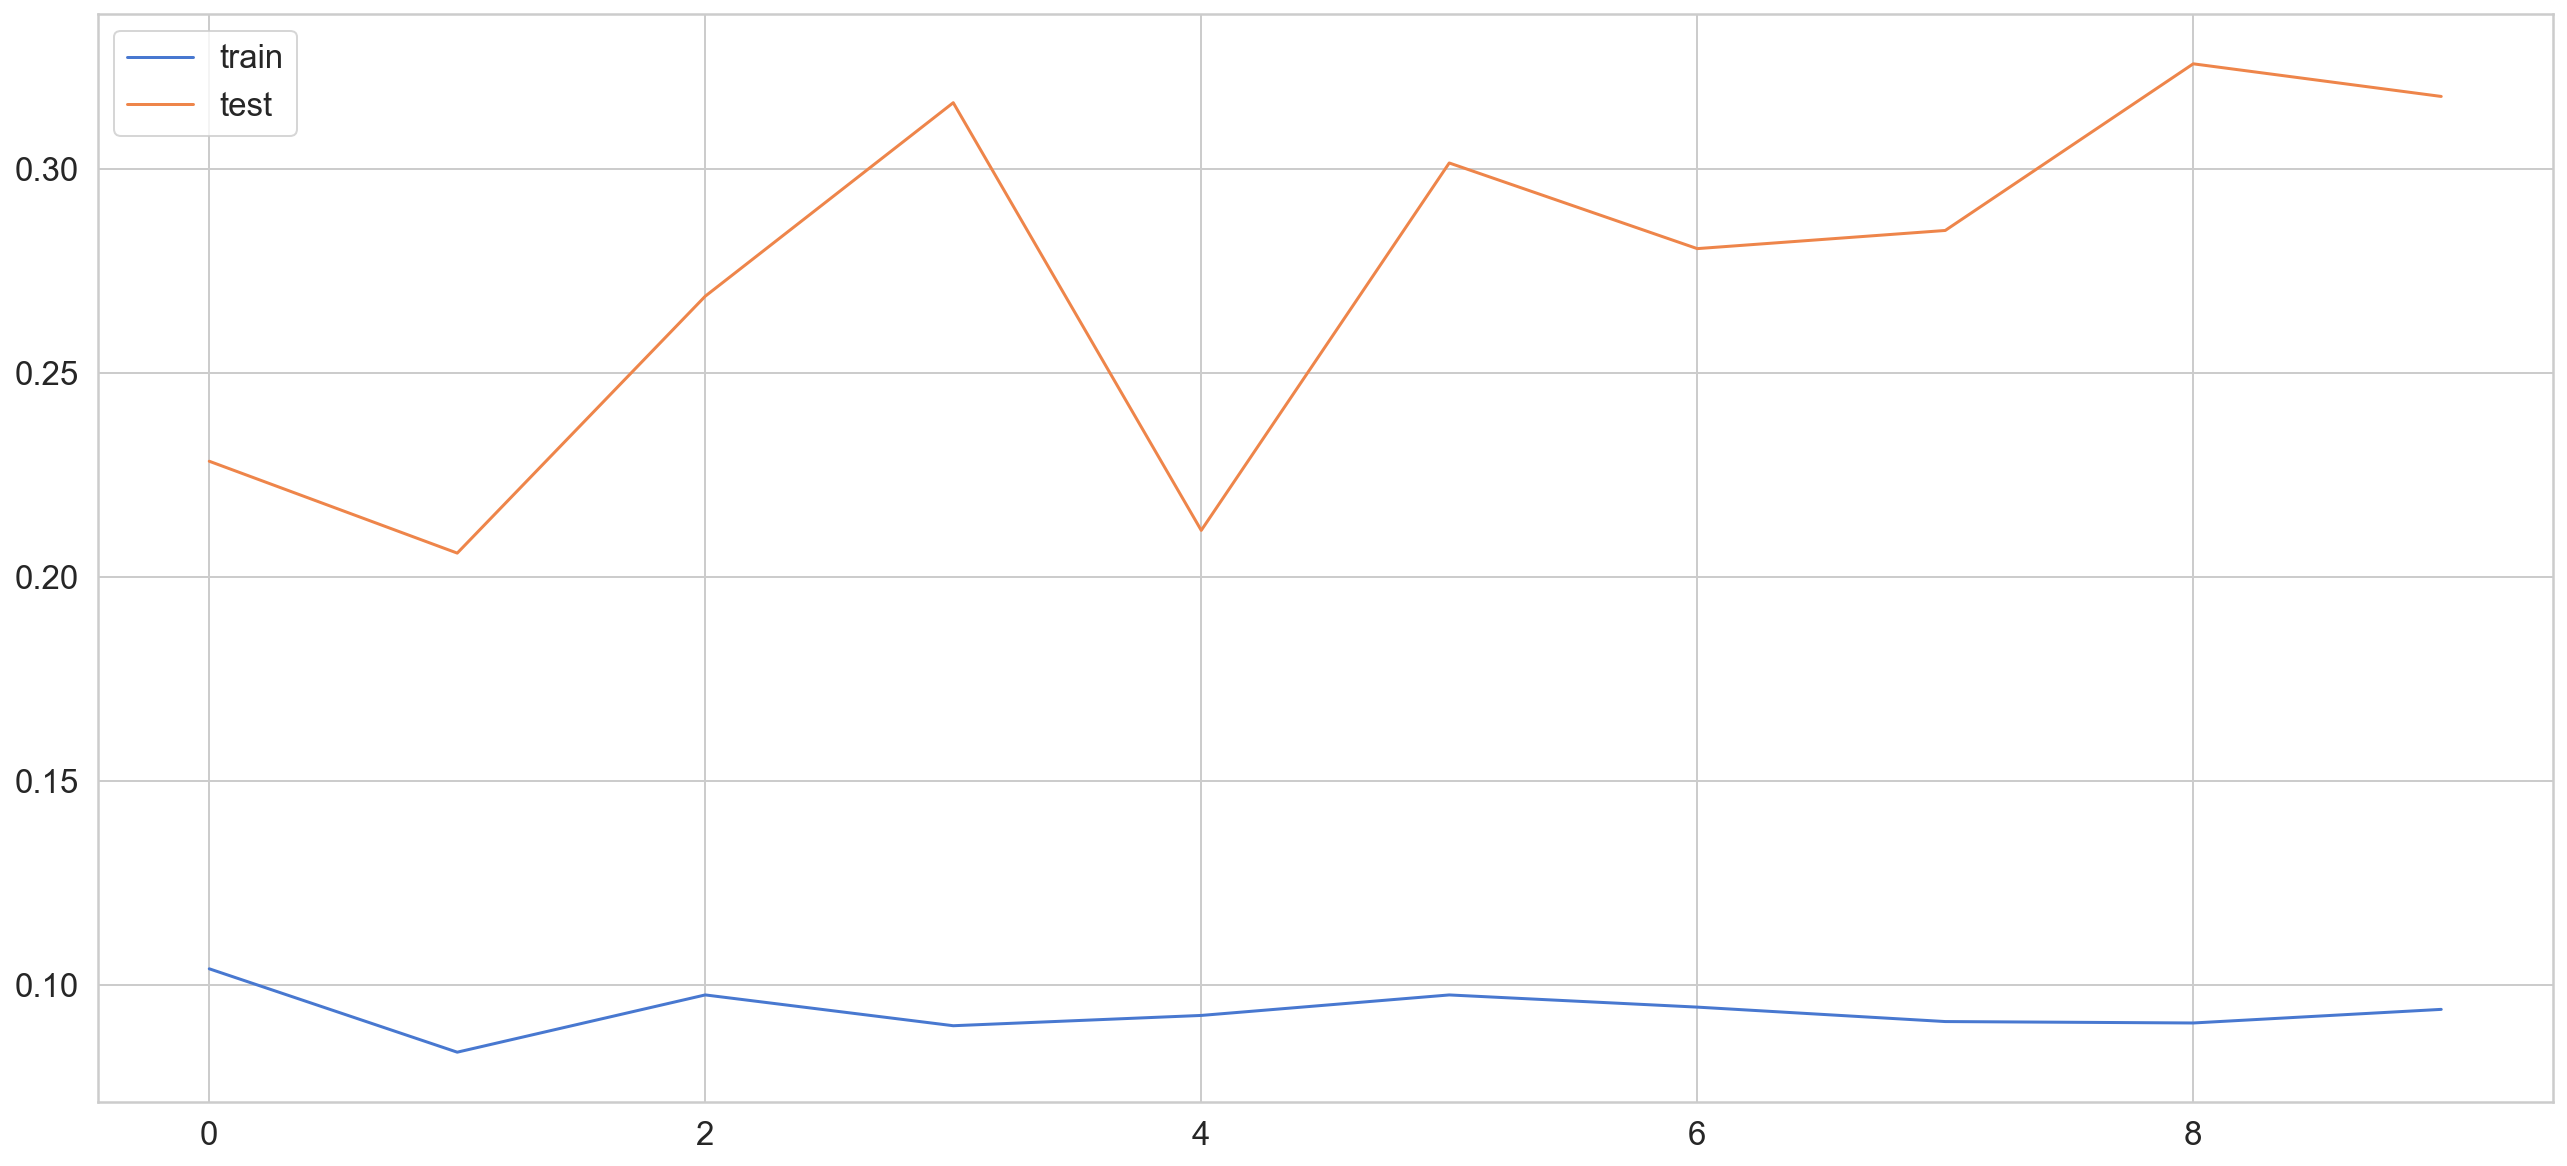

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [26]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred, X_train), axis=1)

243/243 [==============================] - 5s 19ms/step


c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


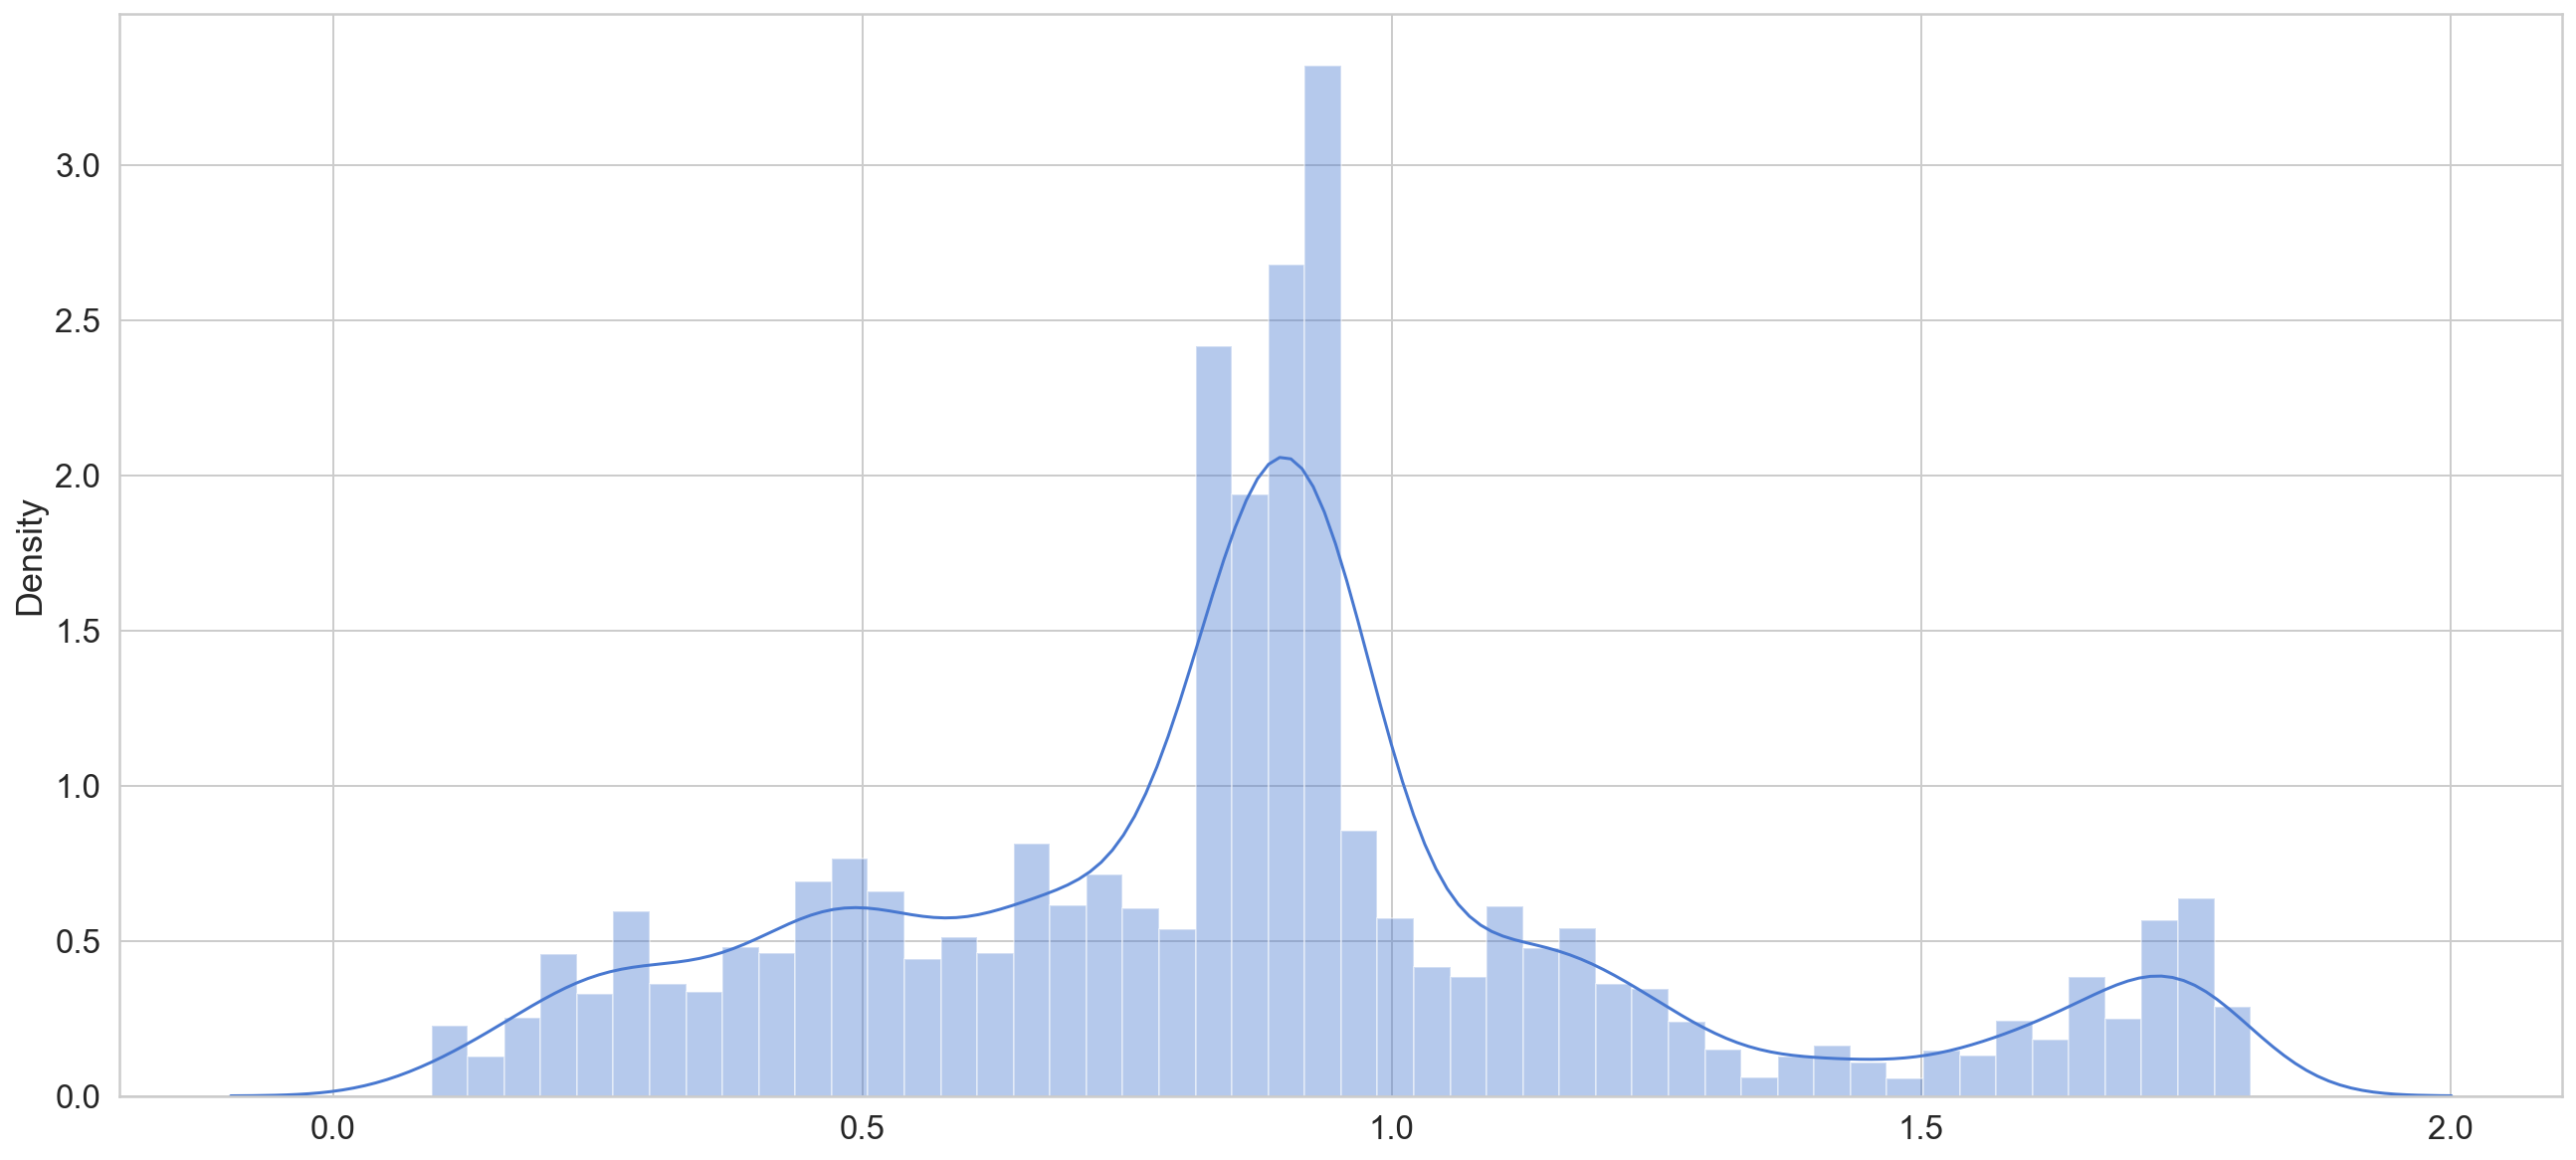

In [27]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [14]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 [==============================] - 0s 15ms/step


In [29]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

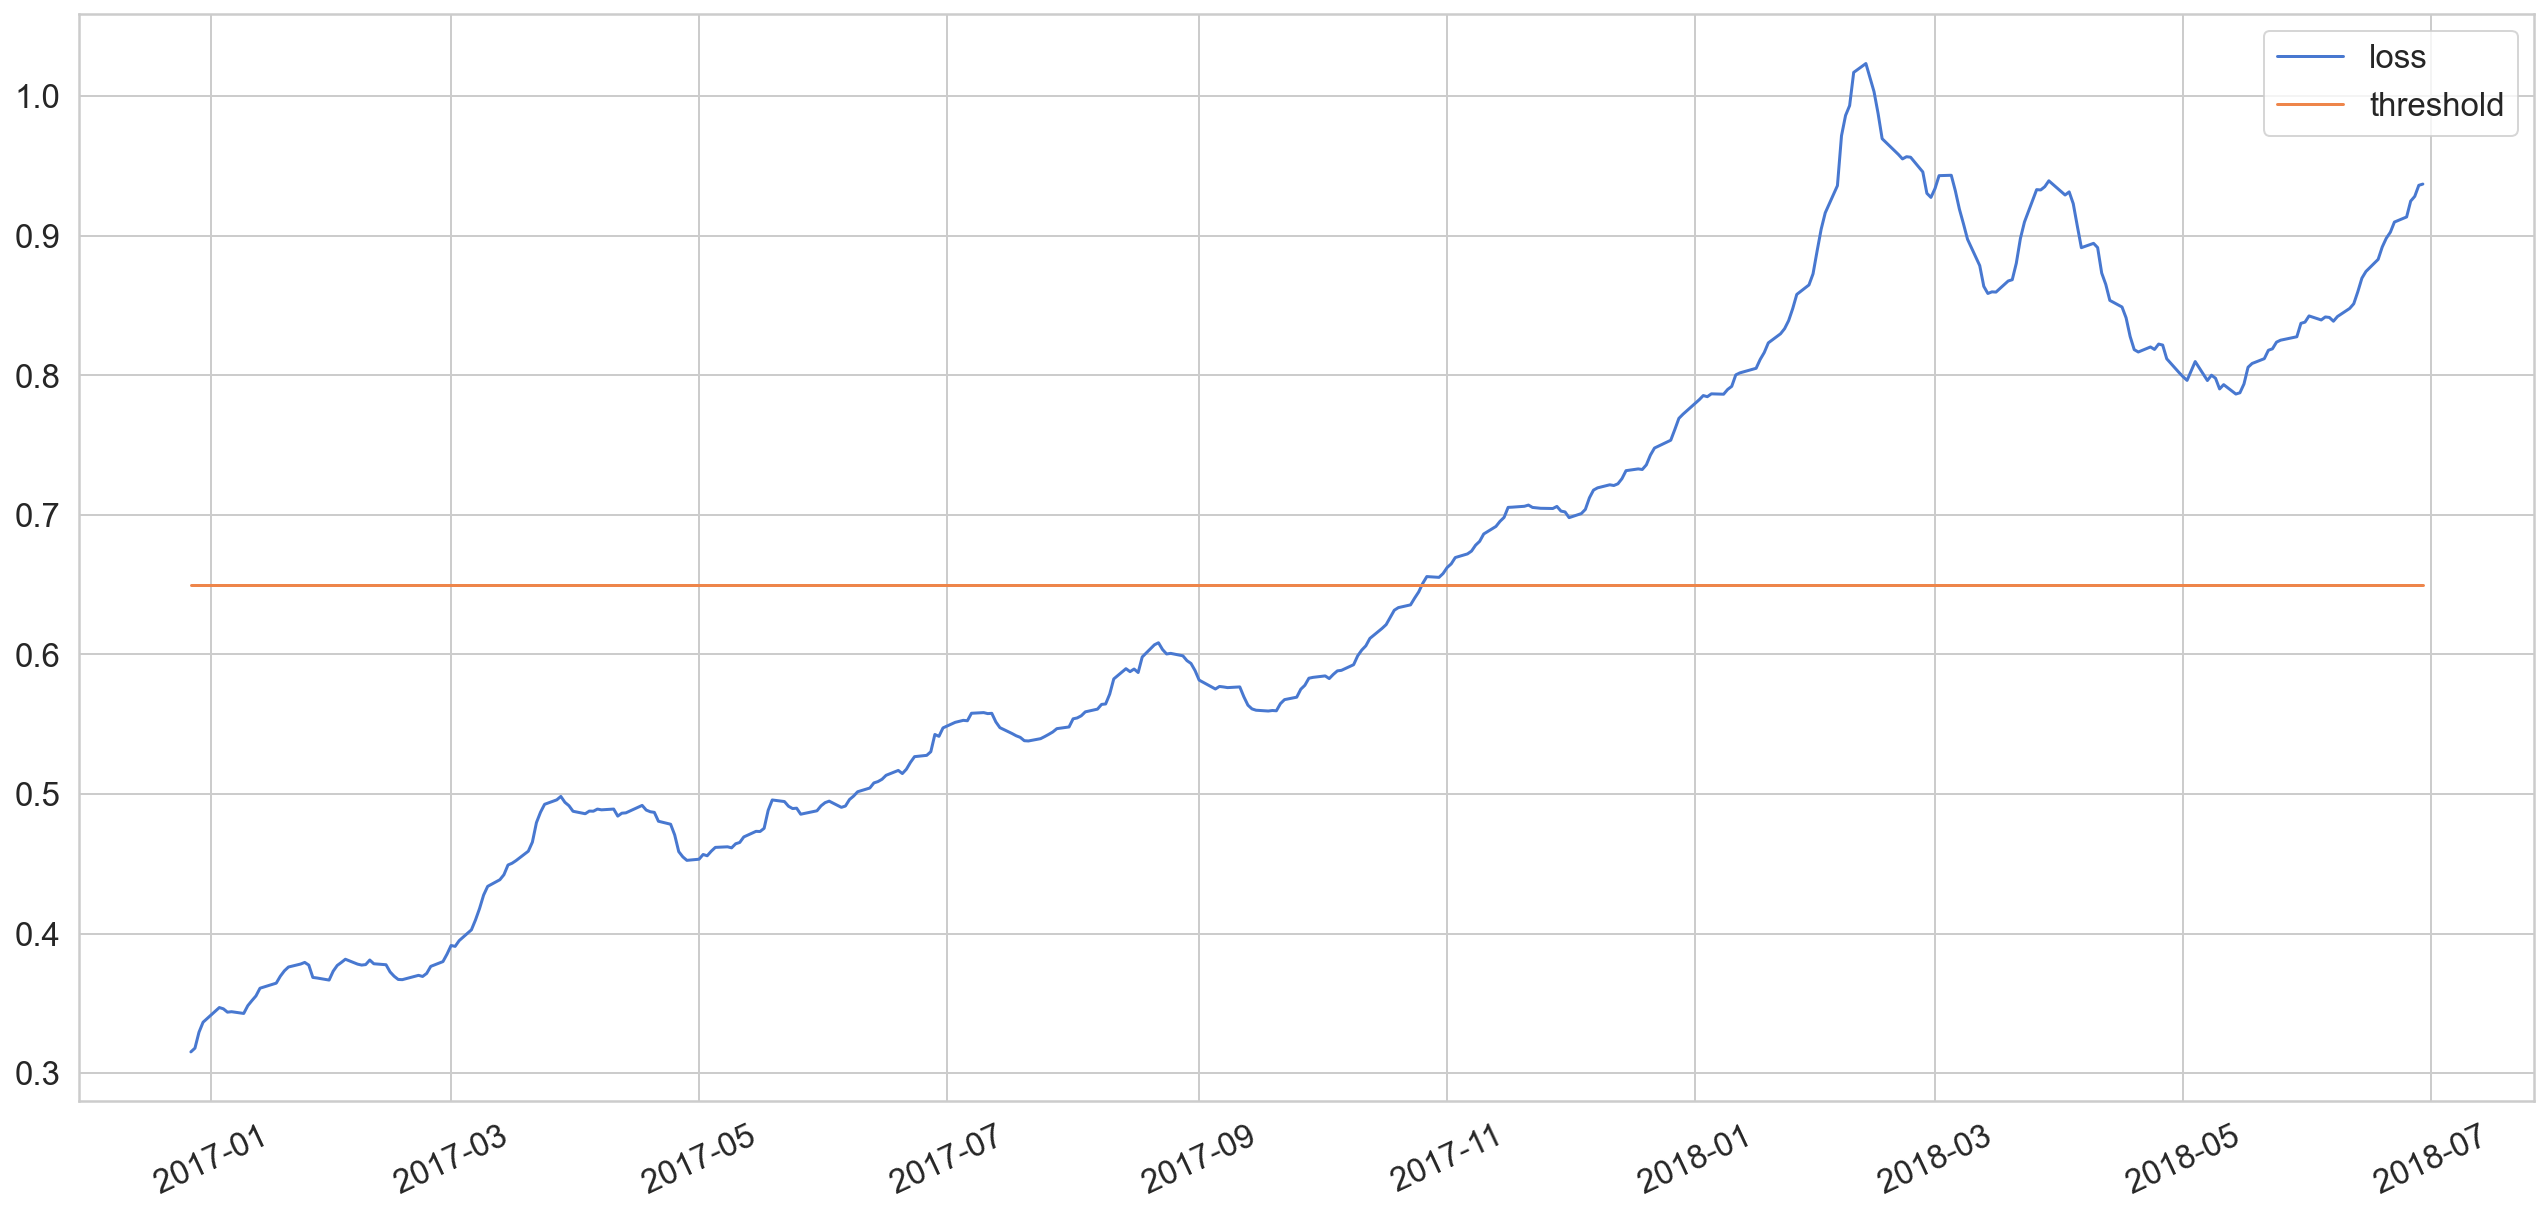

In [30]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [17]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2017-10-26,0.650929,0.65,True,2.940375
2017-10-27,0.655798,0.65,True,2.979199
2017-10-30,0.655242,0.65,True,2.963722
2017-10-31,0.657978,0.65,True,2.968286
2017-11-01,0.662282,0.65,True,2.975987


c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


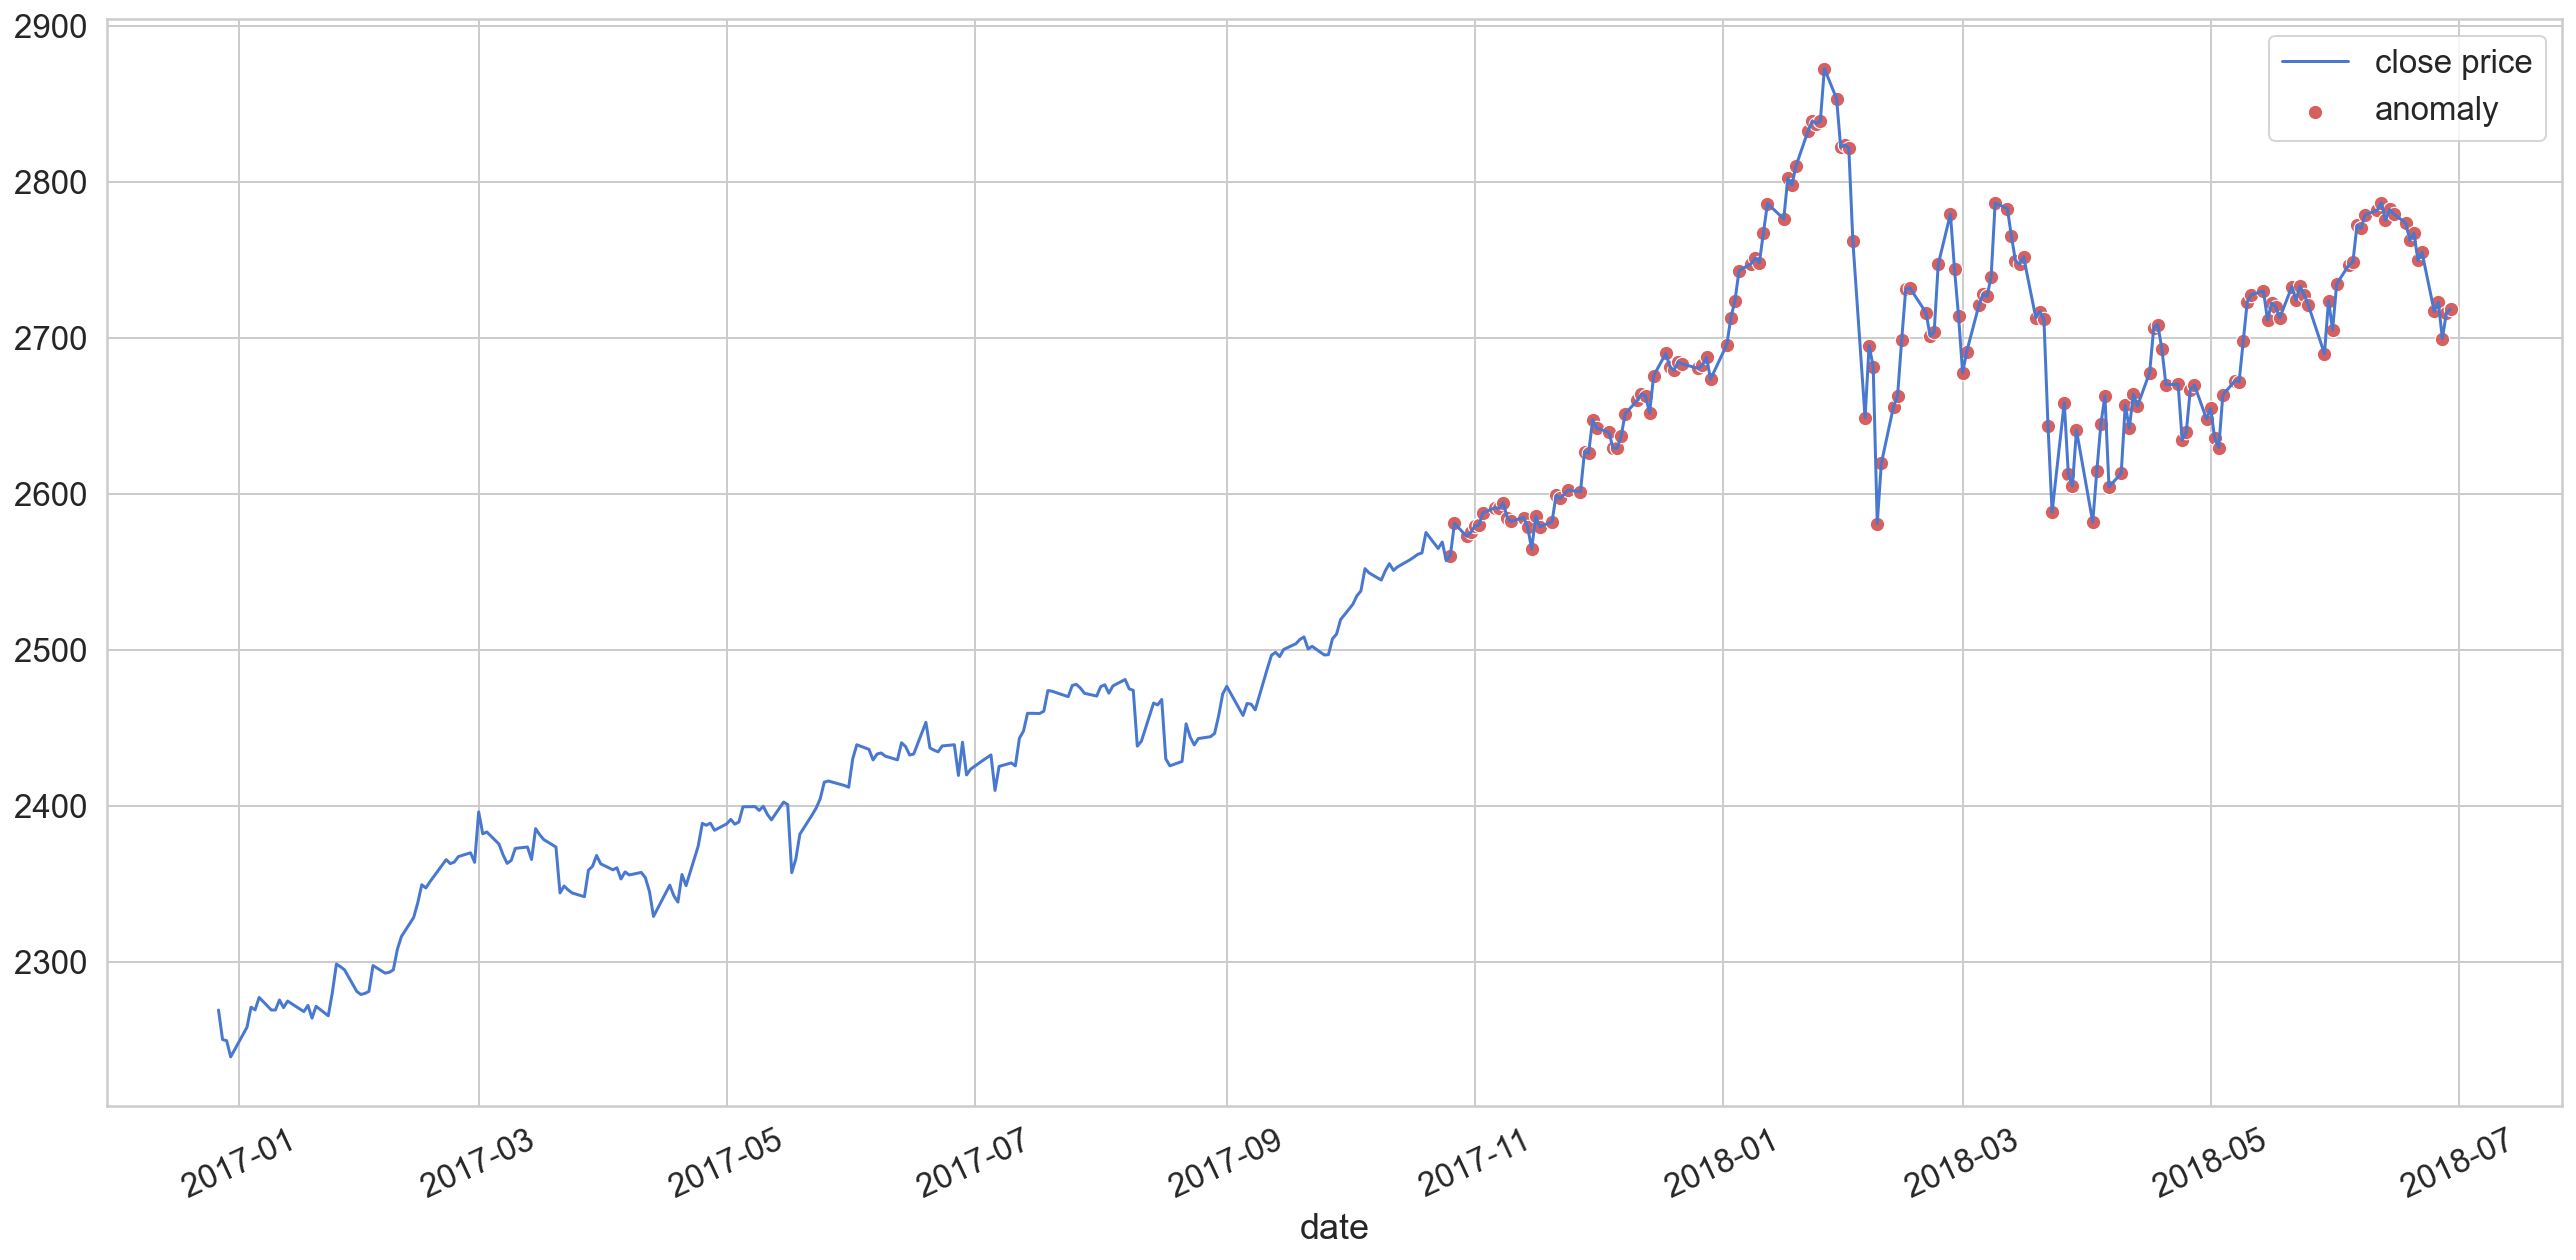

In [31]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close.values.reshape(1,-1)).reshape(-1), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close.values.reshape(1,-1)).reshape(-1),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();